## Words Analysis

This analysis examines collected text and meta-data from scientific articles that mention risk factors for violence and recidivism.

Available information includes the titles, words, and years of all those papers, enabling further exploration and analysis.


In [26]:
%matplotlib inline

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from lisc import Words
from lisc.data import ArticlesAll
from lisc.data.utils import threshold_counter, combine_lists
from lisc.utils import SCDB, load_object
from lisc.io import load_txt_file
from lisc.plts.words import plot_years, plot_wordcloud
from lisc.analysis.words import get_all_counts, get_all_values, get_attribute_counts

In [27]:
import seaborn as sns
sns.set_context('talk')

In [28]:
# Import custom project code
import sys
sys.path.append('../code')
from plts import plot_count_hist, plot_attrs_by_year

## Setup

In [29]:
# Settings
SAVE_FIG = True

In [30]:
# Set the file locations
term_dir = '../terms/'
figs_dir = '../data/figures/words'
import os
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)
from lisc.utils import SCDB
db = SCDB('../data')
#'./data/counts/counts_violence.p

In [31]:
# Set the name of the file to load
name = 'riskfactors'

In [32]:
print(db.get_folder_path('words'))


../data/data/words


In [33]:
# Load the words object
from lisc.io import load_object
words = load_object('words_' + name, directory=db, reload_results=True)

In [34]:
import os
print(os.getcwd())


/Users/davidgallardo-pujol/Documents/GitHub/ViolentRiskFactors/notebooks


In [35]:
# Load exclusions for analysis
from lisc.io import load_txt_file
exclusions = load_txt_file('analysis_exclusions.txt', term_dir, split_elements=False)

### Check Database Information

Check the metadata about the data collection, including checking the database data were collected from.

In [36]:
# Check database scrape info
words.meta_data.db_info

{'dbname': 'pubmed',
 'menuname': 'PubMed',
 'description': 'PubMed bibliographic record',
 'dbbuild': 'Build-2025.02.09.22.23',
 'count': '38375039',
 'lastupdate': '2025/02/09 22:23'}

In [37]:
# Check requester object info
words.meta_data.requester

{'n_requests': 3449,
 'wait_time': 0.3333333333333333,
 'start_time': '11:33:32 Monday 10 February 2025',
 'end_time': '13:29:48 Monday 10 February 2025',
 'logging': None}

## Data Organization

In [38]:
# Process data to collapse across all articles
words.process_combined_results(exclusions=exclusions)

### Check Number of Articles

In [39]:
# Check the number of risk factors
print('Number of risk factors: 	 {}'.format(words.n_terms))

Number of risk factors: 	 62


In [40]:
# Check the total number of articles in the collected dataset
n_articles = [data.n_articles for data in words]
total_article_count = sum(n_articles)
print('Number of articles: \t', total_article_count)

Number of articles: 	 335755


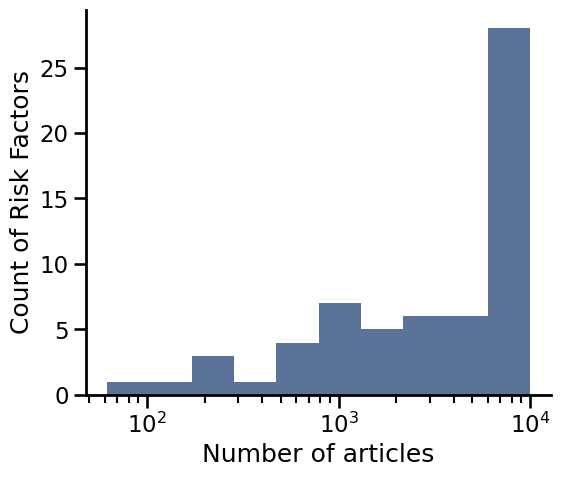

In [41]:
# Plot the histogram of the number of collected articles per risk factor
plot_count_hist(n_articles, log=True, bins=10,
                xlabel='Number of articles', ylabel='Count of Risk Factors',
                save_fig=SAVE_FIG, file_name='riskfactors_hist.pdf', directory=figs_dir)


In [42]:
# Collect all the DOIs across all papers, handling None values
from lisc.analysis.words import get_all_values
all_dois = get_all_values(words, 'dois')
dois = [doi for sublist in all_dois if sublist is not None for doi in sublist]
dois = list(set(dois))  # Remove duplicates



In [43]:
# Check the number of unique papers, based on DOIs
print('Number of unique DOIs:', len(dois))

Number of unique DOIs: 6762


In [44]:
# Check how many articles were found per risk factor
for data in words.results:
    print(data.label, '\t', data.n_articles)

Single-parent family 	 232
Two-parent family 	 1207
Extended family 	 2223
Divorced parents 	 495
Stable family 	 545
Parental conflict 	 1224
Lack of supervision 	 712
Emotional support 	 9967
Family abuse 	 840
External abuse 	 9857
Low income 	 9975
Large family 	 7394
Antisocial thoughts 	 970
Moral reasoning 	 1873
Individualistic attitudes 	 4427
Prosocial attitudes 	 3105
Antisocial attitudes 	 139
Self-preservation beliefs 	 1589
Prosocial beliefs 	 852
Distorted beliefs 	 3350
Individualistic values 	 210
Prosocial values 	 9756
Antisocial values 	 2726
Hostility 	 9973
Anger states 	 9923
Criminal neighborhood 	 4328
Childhood violence 	 2865
Antisocial peers 	 3940
Debt 	 9970
Educational attainment 	 9979
Vocational skills 	 2078
Unemployment 	 9984
Work instability 	 1178
Prenatal tobacco exposure 	 3900
Prenatal alcohol exposure 	 1921
Prenatal drug exposure 	 698
Alcohol use 	 9959
Drug use 	 9948
Impulsivity 	 9982
Lack of empathy 	 1233
Dark traits 	 4349
Attachment st

## Check Attribute Counts

In [45]:
# Define a list of attributes to check
attrs = ['words', 'keywords', 'authors', 'journals', 'dois', 'titles', 'years']

In [46]:
# Check the proportion of papers, for each attribute, that has data
from lisc.analysis.words import get_attribute_counts
print('Attribute counts (total # articles: {}):'.format(total_article_count))
for attr in attrs:
    count = get_attribute_counts(words, attr)
    print('    {:5d} articles ({:6.2f} %) have {}.'.format(\
        count, count / total_article_count * 100, attr))

Attribute counts (total # articles: 335755):
    323439 articles ( 96.33 %) have words.
    212833 articles ( 63.39 %) have keywords.
    334480 articles ( 99.62 %) have authors.
    335755 articles (100.00 %) have journals.
    319212 articles ( 95.07 %) have dois.
    335755 articles (100.00 %) have titles.
    335755 articles (100.00 %) have years.


### Check Years of Publication

In [47]:
# Get global count of authors 
years = set(get_all_values(words, 'years'))
min_year, max_year = min(years), max(years)

In [48]:
# Print out summary of the year range of publications
print('Collected papers were published between the years: {}-{}'.format(min_year, max_year))

Collected papers were published between the years: 1885-2025


In [49]:
# Get the count of articles per year, and drop 2025 (incomplete year)
from lisc.analysis.words import get_all_counts
year_counts = get_all_counts(words, 'years', combine=True)
year_counts.pop(2025);

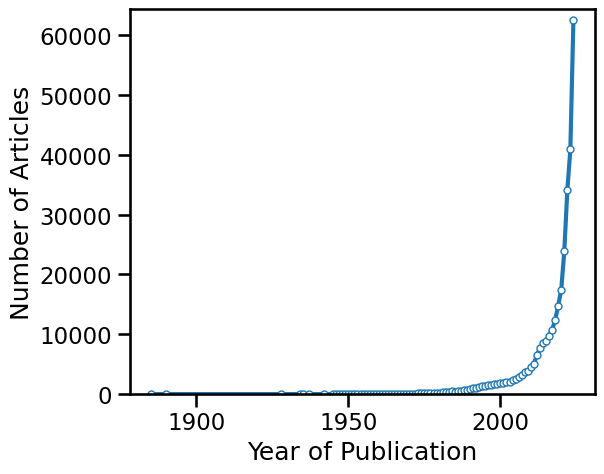

In [50]:
# Plot the total number of articles, across components, per year
plot_years(year_counts, figsize=(6, 5),
           save_fig=SAVE_FIG, file_name='words_year_counts.pdf', directory=figs_dir)

### Check number of distinct risk factors' studies per year

In [51]:
# Collect the set of years each risk factor was studied in
comp_years_all = {}
for label, res in zip(words.labels, words.results):
    comp_years_all[label] = set(res.years)

In [52]:
# Collect the number of unique components studied per year
comp_years = {}
for year in range(min(years), max(years)):
    count = 0
    for temp in comp_years_all.values():
        count += 1 if year in temp else 0
    comp_years[year] = count

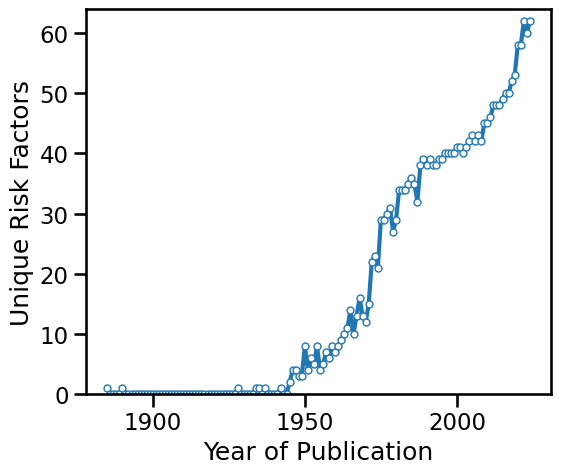

In [53]:
# Plot the number of unique components studied per year
plot_years(comp_years, ylabel='Unique Risk Factors', figsize=(6, 5),
           save_fig=SAVE_FIG, file_name='words_year_risk_factors.pdf', directory=figs_dir)

### Check Authors across all papers

In [54]:
# Get global count of authors 
author_counts = get_all_counts(words, 'authors', combine=True)

In [55]:
# Check the number of unique authors
print('Total number of authors   :\t {:5d}'.format(len(author_counts)))
print('Number of authors > 10   :\t {:5d}'.format(len(threshold_counter(author_counts, 10))))
print('Number of authors > 100  :\t {:5d}'.format(len(threshold_counter(author_counts, 100))))

Total number of authors   :	 678167
Number of authors > 10   :	 24963
Number of authors > 100  :	   600


In [56]:
# Check the most common authors
print('Most common authors:')
for (author, count) in author_counts.most_common(10):
    print('    {:15s} \t {}'.format(' '.join(author), count))

Most common authors:
    Wang Y          	 2226
    Zhang Y         	 2020
    Li Y            	 1804
    Wang X          	 1652
    Liu Y           	 1618
    Wang J          	 1559
    Li X            	 1427
    Li J            	 1396
    Zhang J         	 1262
    Zhang X         	 1218


### Check Journals across all papers

In [57]:
# Get global count of journals
journals_counts = get_all_counts(words, 'journals', combine=True)

In [58]:
# Check the number of unique authors
print('Total number of journals  :\t {:5d}'.format(len(journals_counts)))
print('Number of journals > 10   :\t {:5d}'.format(len(threshold_counter(journals_counts, 10))))
print('Number of journals > 100  :\t {:5d}'.format(len(threshold_counter(journals_counts, 100))))

Total number of journals  :	 11602
Number of journals > 10   :	  4270
Number of journals > 100  :	   659


In [59]:
# Check the most common journals
print('Most common journals:')
for (journal, count) in journals_counts.most_common(10):
    print('    {:55s} \t {}'.format(journal.split(':')[0], count))

Most common journals:
    PloS one                                                	 6586
    Frontiers in psychology                                 	 4777
    International journal of environmental research and public health 	 4315
    Frontiers in psychiatry                                 	 3222
    Scientific reports                                      	 2931
    Journal of affective disorders                          	 2511
    BMC public health                                       	 2428
    Cureus                                                  	 2375
    Psychiatry research                                     	 2011
    Frontiers in public health                              	 1888


### Keywords

In [60]:
# Get global count of authors 
kw_counts = get_all_counts(words, 'keywords', combine=True)

In [62]:
# Check the number of unique keywords
print('Total number of keywords   :\t {:5d}'.format(len(kw_counts)))
print('Number of keywords > 10    :\t {:5d}'.format(len(threshold_counter(kw_counts, 10))))
print('Number of keywords > 100   :\t {:5d}'.format(len(threshold_counter(kw_counts, 100))))

Total number of keywords   :	 238117
Number of keywords > 10    :	 12883
Number of keywords > 100   :	  1323


In [63]:
# Check the most common keywords across all components
print('Most common keywords:')
for (kw, count) in kw_counts.most_common(10):
    print('    {:20s} \t {}'.format(kw, count))

Most common keywords:
    covid-19             	 9359
    mental health        	 9115
    depression           	 8586
    anxiety              	 5448
    personality          	 4825
    adolescents          	 3754
    alcohol              	 3082
    stress               	 3013
    borderline personality disorder 	 2867
    adolescence          	 2774


In [65]:
# Check most common keywords per risk factor
for data in words.combined_results:
    data.check_frequencies('keywords', n_check=5)

Single-parent family : family structure, adolescents, children, adolescent, family
Two-parent family : family and household, family characteristics, population, demographic factors, developing countries
Extended family : family, social support, mental health, covid-19, children
Divorced parents : divorce, marriage, gender, mental health, adolescents
Stable family : adolescents, mental health, family support, adolescent, adolescence
Parental conflict : parenting, depression, adolescent, adolescents, children
Lack of supervision : developing countries, health, neglect, primary health care, delivery of health care
Emotional support : covid-19, mental health, depression, social support, anxiety
Family abuse : domestic violence, intimate partner violence, covid-19, women, mental health
External abuse : alcohol, opioid use disorder, substance use, mental health, child abuse
Low income : covid-19, mental health, public health, social determinants of health, epidemiology
Large family : family 

### Abstract Words

In [66]:
# Get global count of words 
word_counts = get_all_counts(words, 'words', combine=True)

In [67]:
# Check the number of unique words
print('Total number of words   :\t {:5d}'.format(len(word_counts)))
print('Number of words > 100   :\t {:5d}'.format(len(threshold_counter(word_counts, 100))))
print('Number of words > 1000  :\t {:5d}'.format(len(threshold_counter(word_counts, 1000))))

Total number of words   :	 810710
Number of words > 100   :	 23561
Number of words > 1000  :	  5517


In [68]:
# Check the most common keywords across all risk factors
print('Most common words:')
for (word, count) in word_counts.most_common(10):
    print('    {:20s} \t {}'.format(word, count))

Most common words:
    study                	 329903
    health               	 275127
    patients             	 236498
    use                  	 194639
    associated           	 182071
    among                	 155039
    data                 	 151338
    social               	 150260
    risk                 	 147207
    using                	 144403


In [69]:
# Check most common words
for data in words.combined_results:
    data.check_frequencies('words', n_check=5)

Single-parent family : family, children, single-parent, study, risk
Two-parent family : family, nuclear, study, children, families
Extended family : family, extended, study, children, health
Divorced parents : parents, marital, children, study, divorce
Stable family : family, study, health, children, support
Parental conflict : conflict, marital, family, study, children
Lack of supervision : health, supervision, study, care, lack
Emotional support : support, health, care, study, patients
Family abuse : abuse, domestic, violence, women, health
External abuse : use, study, treatment, patients, health
Low income : health, study, data, among, care
Large family : family, large, proteins, gene, protein
Antisocial thoughts : antisocial, behavior, personality, study, psychopathy
Moral reasoning : moral, reasoning, study, social, decision-making
Individualistic attitudes : autonomy, patients, care, health, values
Prosocial attitudes : social, responsibility, health, csr, study
Antisocial attitu

## Check Values by Year

In [70]:
# Extract lists of all values for attributes of interest
all_years = get_all_values(words, 'years')
all_journals = get_all_values(words, 'journals')
all_authors = get_all_values(words, 'authors')

In [71]:
# Collect the number of unique journals & authors by year
journals_by_year = {}
authors_by_year = {}
for year in range(min_year, max_year):
    inds = np.where(np.array(all_years) == year)[0]
    journals_by_year[year] = len(set(np.array(all_journals)[inds]))
    authors_by_year[year] = len(set(combine_lists([all_authors[ind] for ind in inds])))

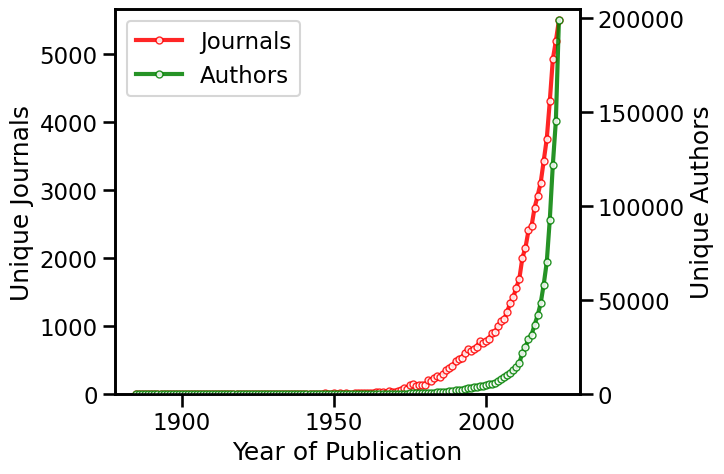

In [72]:
# Plot unique journals & authors by year
plot_attrs_by_year(journals_by_year, authors_by_year, figsize=(6, 5),
                   save_fig=SAVE_FIG, file_name='words_attr_year.pdf', directory=figs_dir)

## Example Risk Factor Summaries

In [73]:
# Set indices for some example risk factors
inds = [27, 40]
print(words.labels[inds[0]], words.labels[inds[1]])

Antisocial peers Dark traits


In [74]:
# Check some example summaries
for ind in inds:
    words.combined_results[ind].create_summary()
    words.combined_results[ind].print_summary()

Antisocial peers :
  Number of articles: 		 3940
  First publication: 		 1885
  Most common author: 		 Cauffman E
    number of publications: 	 53
  Most common journal: 		 Journal of youth and adolescence
    number of publications: 	 158 

Dark traits :
  Number of articles: 		 4349
  First publication: 		 1934
  Most common author: 		 Kiehl KA
    number of publications: 	 120
  Most common journal: 		 Personality disorders
    number of publications: 	 153 



### WordCloud Plots

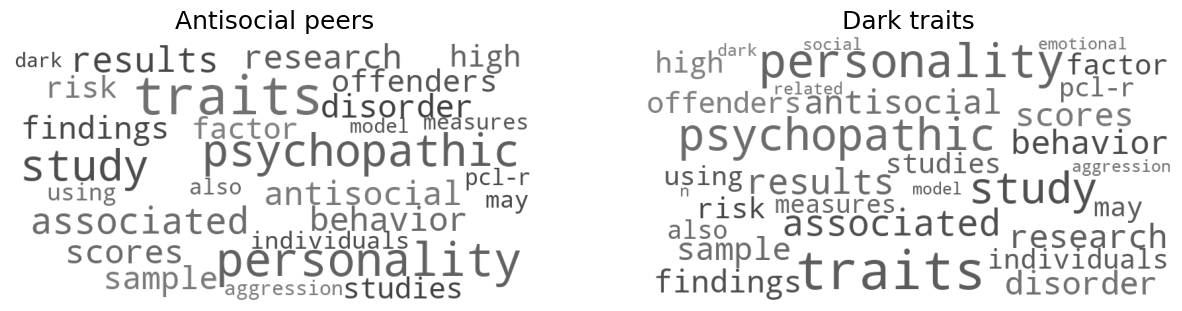

In [75]:
# Create wordclouds
_, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_wordcloud(words.combined_results[ind].words, inds[0], ax=axes[0])
axes[0].set_title(words.labels[inds[0]]);
plot_wordcloud(words.combined_results[ind].words, inds[1], ax=axes[1])
axes[1].set_title(words.labels[inds[1]]);

### History Plots

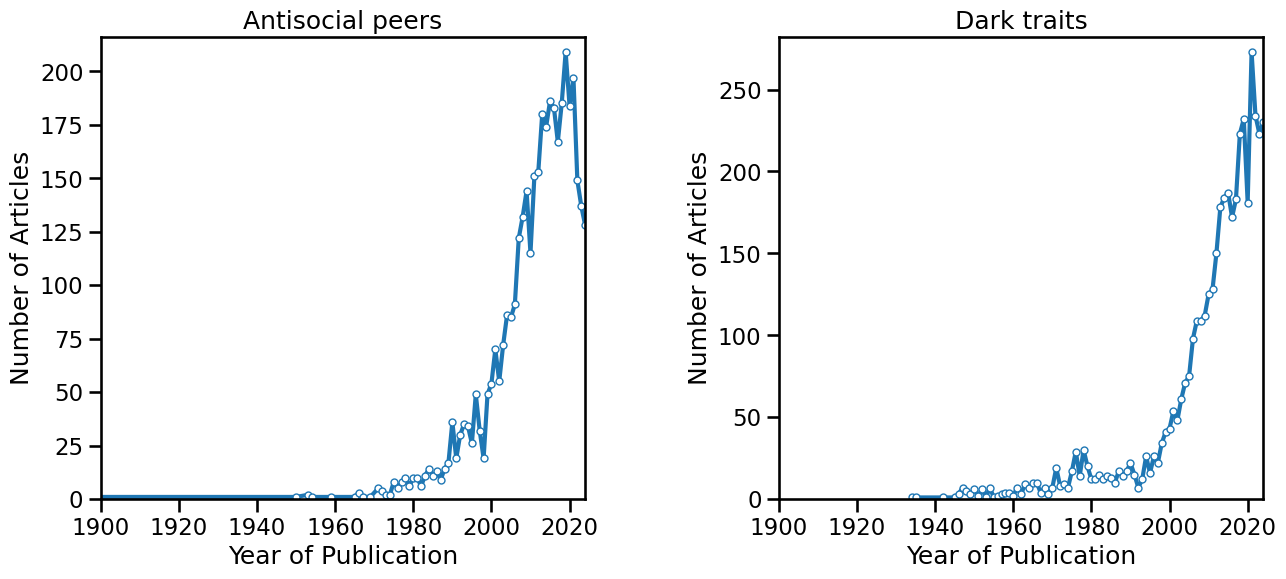

In [81]:
# Check an example history plot



import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plt.subplots_adjust(wspace=0.4)  # Augmenta l'espai horitzontal entre els gràfics

plot_years(words.combined_results[inds[0]].years, [None, 2024], ax=axes[0])
axes[0].set_title(words.labels[inds[0]]);

plot_years(words.combined_results[inds[1]].years, [None, 2024], ax=axes[1])
axes[1].set_title(words.labels[inds[1]]);

import numpy as np

# Set x-axis limits for both subplots
axes[0].set_xlim(1900, 2024);
axes[1].set_xlim(1900, 2024);

# Define tick marks every 20 years (adjust as needed)
ticks = np.arange(1900, 2024, 20);
axes[0].set_xticks(ticks);
axes[1].set_xticks(ticks);

